# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, we compare the performance of four classifiers — K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines — on a dataset related to marketing bank products over the telephone.

**Dataset**: UCI Machine Learning Repository — [Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing)  
**Source**: Portuguese banking institution, multiple telephone marketing campaigns (May 2008 – November 2010)

---
## Problem 1: Understanding the Data

According to the accompanying paper (Moro et al.), the dataset was collected from **17 marketing campaigns** that occurred between May 2008 and November 2010, totaling 79,354 contacts (in the original study). The publicly available version we use contains 41,188 records with 20 input features and 1 binary target variable.

The campaigns were conducted via telephone to promote long-term bank deposit subscriptions.

---
## Problem 2: Read in the Data

In [21]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, f1_score, roc_auc_score,
                             ConfusionMatrixDisplay, RocCurveDisplay)

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')

In [22]:
# Read the data (semicolon-separated)
df = pd.read_csv('data/bank-additional-full.csv', sep=';')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


---
## Problem 3: Understanding the Features

In [23]:
# Data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [24]:
# Descriptive statistics for numeric features
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [25]:
# Check for 'unknown' values in categorical columns (these act as missing values)
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("=== 'Unknown' counts in categorical features ===")
for col in cat_cols:
    unk = (df[col] == 'unknown').sum()
    if unk > 0:
        print(f"  {col}: {unk} unknowns ({unk/len(df)*100:.1f}%)")

print(f"\nNo traditional NaN missing values: {df.isnull().sum().sum()} NaN total")
print("\nNote: 'unknown' values serve as missing data placeholders.")
print("The 'default' column has 20.9% unknowns — this is significant.")

=== 'Unknown' counts in categorical features ===
  job: 330 unknowns (0.8%)
  marital: 80 unknowns (0.2%)
  education: 1731 unknowns (4.2%)
  default: 8597 unknowns (20.9%)
  housing: 990 unknowns (2.4%)
  loan: 990 unknowns (2.4%)

No traditional NaN missing values: 0 NaN total

Note: 'unknown' values serve as missing data placeholders.
The 'default' column has 20.9% unknowns — this is significant.


In [26]:
# Check unique values for each categorical column
for col in cat_cols:
    print(f"{col}: {df[col].nunique()} unique -> {df[col].unique()}")

job: 12 unique -> ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital: 4 unique -> ['married' 'single' 'divorced' 'unknown']
education: 8 unique -> ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default: 3 unique -> ['no' 'unknown' 'yes']
housing: 3 unique -> ['no' 'yes' 'unknown']
loan: 3 unique -> ['no' 'yes' 'unknown']
contact: 2 unique -> ['telephone' 'cellular']
month: 10 unique -> ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week: 5 unique -> ['mon' 'tue' 'wed' 'thu' 'fri']
poutcome: 3 unique -> ['nonexistent' 'failure' 'success']
y: 2 unique -> ['no' 'yes']


**Observations on Features:**
- There are no traditional NaN missing values, but several categorical columns contain `'unknown'` entries acting as missing data.
- The `default` column has 20.9% unknowns — very high. The `education` column has 4.2% unknowns.
- The `duration` feature should be dropped for realistic modeling (as noted in the data description — it is only known after the call ends).
- The `pdays` column uses 999 to indicate "client was not previously contacted" — this is present in a large majority of records.
- No data type coercion is needed — numeric columns are already numeric and categorical columns are strings.

---
## Problem 4: Understanding the Task — Business Objective

**Business Objective:** The goal is to predict whether a client will subscribe to a term deposit (`y = 'yes'`) based on client demographics, campaign contact details, and socio-economic indicators. A successful predictive model can help the bank:

1. **Increase campaign efficiency** by targeting clients who are more likely to subscribe, reducing the number of unnecessary calls.
2. **Reduce costs** (human effort, phone time) by focusing resources on high-probability prospects.
3. **Identify key factors** that influence subscription success to guide future marketing strategy.

This is a **binary classification** problem: predict `y` (yes/no) for term deposit subscription.

In [27]:
# Target variable distribution
print("Target variable distribution:")
print(df['y'].value_counts())
print(f"\nSubscription rate: {(df['y']=='yes').mean()*100:.1f}%")
print("\nThe dataset is highly imbalanced — only ~11.3% of contacts resulted in a subscription.")

Target variable distribution:
y
no     36548
yes     4640
Name: count, dtype: int64

Subscription rate: 11.3%

The dataset is highly imbalanced — only ~11.3% of contacts resulted in a subscription.


---
## Exploratory Data Analysis (EDA)

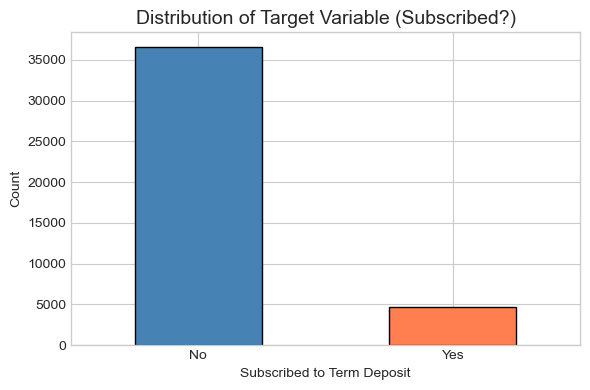

In [28]:
# Target distribution plot
fig, ax = plt.subplots(figsize=(6, 4))
df['y'].value_counts().plot(kind='bar', color=['steelblue', 'coral'], edgecolor='black', ax=ax)
ax.set_title('Distribution of Target Variable (Subscribed?)', fontsize=14)
ax.set_xlabel('Subscribed to Term Deposit')
ax.set_ylabel('Count')
ax.set_xticklabels(['No', 'Yes'], rotation=0)
plt.tight_layout()
plt.show()

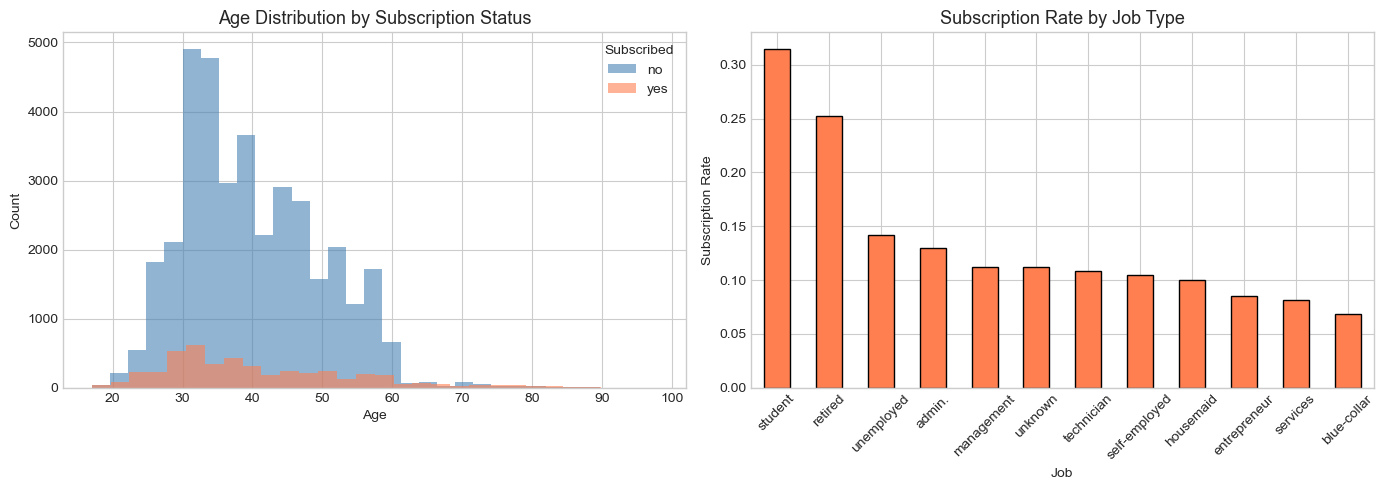

In [29]:
# Age distribution by subscription status
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Age histogram
for label, color in [('no', 'steelblue'), ('yes', 'coral')]:
    df[df['y']==label]['age'].hist(bins=30, alpha=0.6, label=label, color=color, ax=axes[0])
axes[0].set_title('Age Distribution by Subscription Status', fontsize=13)
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')
axes[0].legend(title='Subscribed')

# Job distribution
job_sub = df.groupby('job')['y'].apply(lambda x: (x=='yes').mean()).sort_values(ascending=False)
job_sub.plot(kind='bar', color='coral', edgecolor='black', ax=axes[1])
axes[1].set_title('Subscription Rate by Job Type', fontsize=13)
axes[1].set_xlabel('Job')
axes[1].set_ylabel('Subscription Rate')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

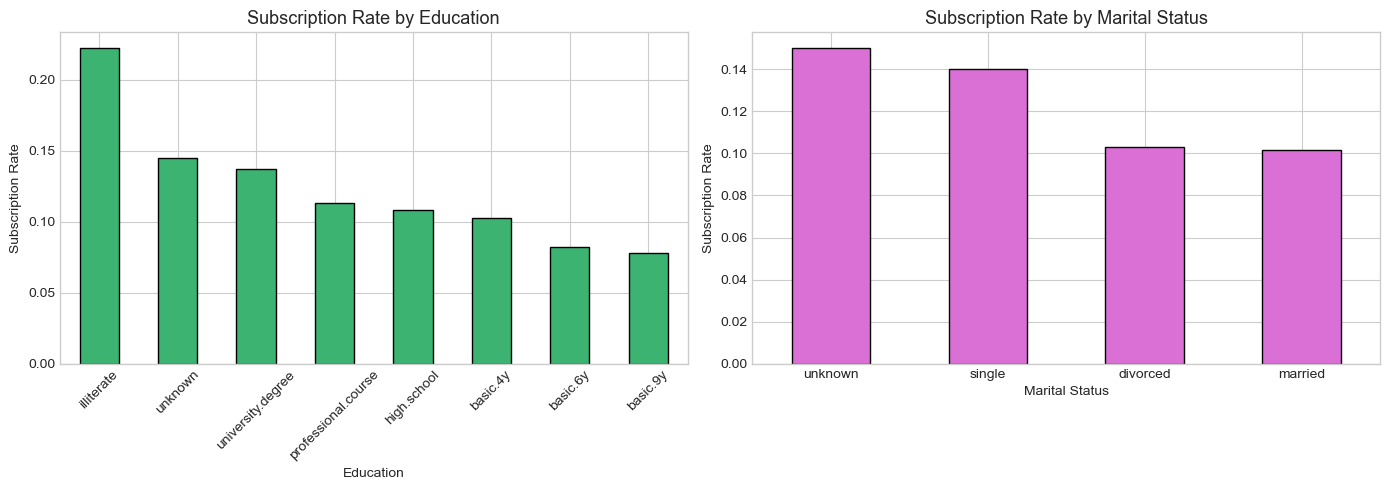

In [30]:
# Subscription rate by education and marital status
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

edu_sub = df.groupby('education')['y'].apply(lambda x: (x=='yes').mean()).sort_values(ascending=False)
edu_sub.plot(kind='bar', color='mediumseagreen', edgecolor='black', ax=axes[0])
axes[0].set_title('Subscription Rate by Education', fontsize=13)
axes[0].set_xlabel('Education')
axes[0].set_ylabel('Subscription Rate')
axes[0].tick_params(axis='x', rotation=45)

mar_sub = df.groupby('marital')['y'].apply(lambda x: (x=='yes').mean()).sort_values(ascending=False)
mar_sub.plot(kind='bar', color='orchid', edgecolor='black', ax=axes[1])
axes[1].set_title('Subscription Rate by Marital Status', fontsize=13)
axes[1].set_xlabel('Marital Status')
axes[1].set_ylabel('Subscription Rate')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

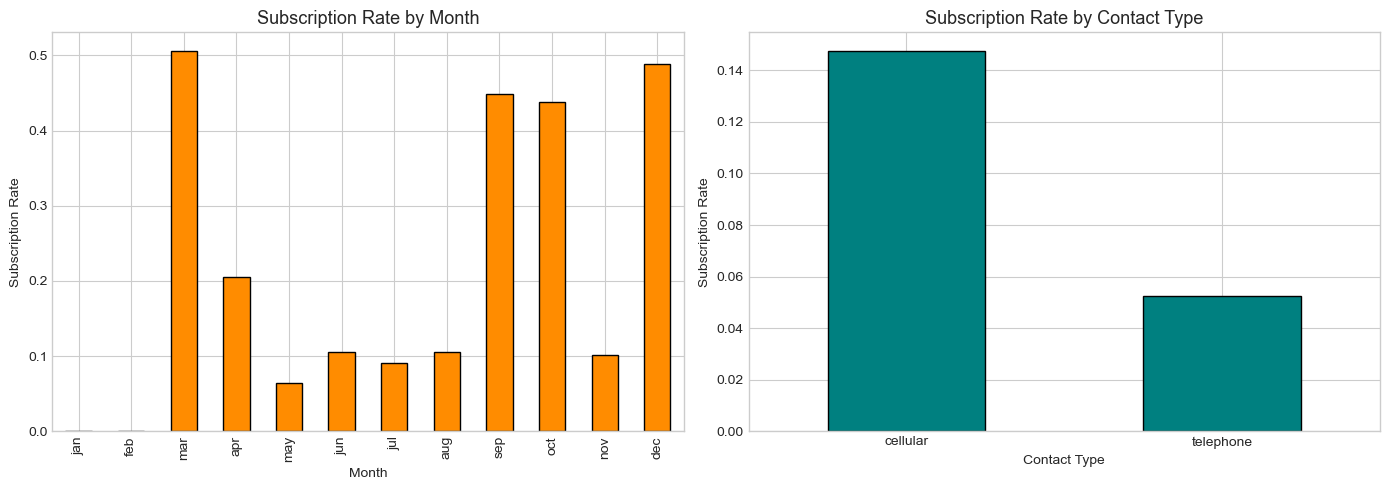

In [31]:
# Subscription rate by month and contact type
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

month_order = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
month_sub = df.groupby('month')['y'].apply(lambda x: (x=='yes').mean()).reindex(month_order)
month_sub.plot(kind='bar', color='darkorange', edgecolor='black', ax=axes[0])
axes[0].set_title('Subscription Rate by Month', fontsize=13)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Subscription Rate')

contact_sub = df.groupby('contact')['y'].apply(lambda x: (x=='yes').mean()).sort_values(ascending=False)
contact_sub.plot(kind='bar', color='teal', edgecolor='black', ax=axes[1])
axes[1].set_title('Subscription Rate by Contact Type', fontsize=13)
axes[1].set_xlabel('Contact Type')
axes[1].set_ylabel('Subscription Rate')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

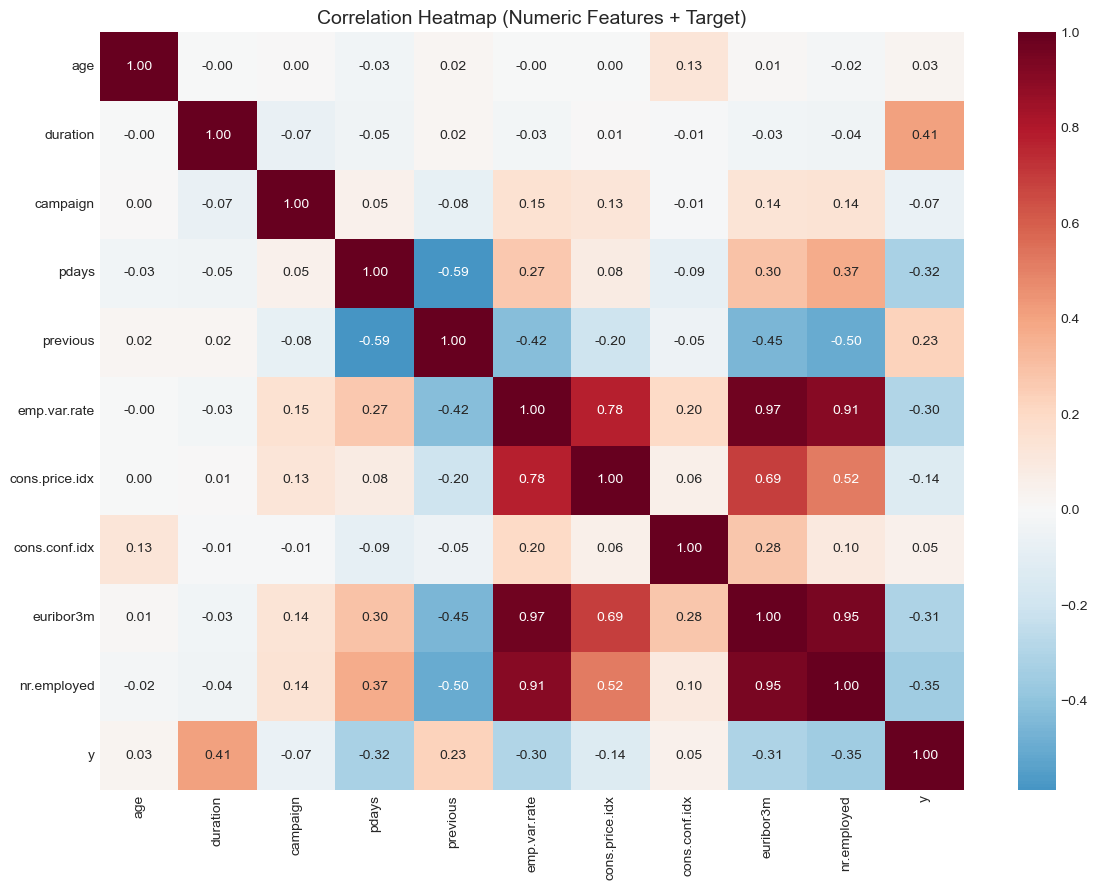

In [32]:
# Correlation heatmap for numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
fig, ax = plt.subplots(figsize=(12, 9))
# Add y as numeric for correlation
df_corr = df[numeric_cols].copy()
df_corr['y'] = (df['y']=='yes').astype(int)
sns.heatmap(df_corr.corr(), annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax)
ax.set_title('Correlation Heatmap (Numeric Features + Target)', fontsize=14)
plt.tight_layout()
plt.show()

**EDA Takeaways:**
- Retired and student clients seem to subscribe more often than other job types.
- Calling on cell phones works better than regular telephone.
- Some months (March, September, October, December) have noticeably higher subscription rates.
- The economic indicators (euribor3m, nr.employed, emp.var.rate) are highly correlated with each other and also seem related to the target variable.
- The dataset is really imbalanced — about 88.7% "no" vs. 11.3% "yes".

---
## Problem 5: Engineering Features

In [33]:
# Prepare features for modeling

# Drop 'duration' — it is not available before a call and should not be used for realistic prediction
df_model = df.drop(columns=['duration'])

# Encode target: yes=1, no=0
df_model['y'] = (df_model['y'] == 'yes').astype(int)

# One-hot encode all categorical features
cat_cols = df_model.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns to encode: {cat_cols}")

df_encoded = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)
print(f"\nShape after encoding: {df_encoded.shape}")
df_encoded.head()

Categorical columns to encode: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

Shape after encoding: (41188, 53)


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,True,False,False,False,True,False,False,False,True,False
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,True,False,False,False,True,False,False,False,True,False
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,True,False,False,False,True,False,False,False,True,False
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,True,False,False,False,True,False,False,False,True,False
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,True,False,False,False,True,False,False,False,True,False


In [34]:
# Separate features and target
X = df_encoded.drop(columns=['y'])
y = df_encoded['y']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts()}")

Features shape: (41188, 52)
Target shape: (41188,)
Target distribution:
y
0    36548
1     4640
Name: count, dtype: int64


---
## Problem 6: Train/Test Split

In [35]:
# Split data into 70% train and 30% test, stratified to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"\nTest target distribution:\n{y_test.value_counts(normalize=True)}")

Training set: (28831, 52)
Test set: (12357, 52)

Training target distribution:
y
0    0.887343
1    0.112657
Name: proportion, dtype: float64

Test target distribution:
y
0    0.887351
1    0.112649
Name: proportion, dtype: float64


In [36]:
# Scale features — important for KNN, SVM, and Logistic Regression
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
print("Features scaled using StandardScaler.")

Features scaled using StandardScaler.


---
## Problem 7: A Baseline Model

In [37]:
# Baseline: always predict the majority class ('no' = 0)
baseline_accuracy = y_test.value_counts(normalize=True).max()
print(f"Baseline Accuracy (always predict 'no'): {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")
print(f"\nAny useful model must beat this {baseline_accuracy*100:.1f}% baseline.")
print("However, accuracy alone is misleading with imbalanced data.")
print("We will also evaluate using F1-score, which balances precision and recall for the minority class.")

Baseline Accuracy (always predict 'no'): 0.8874 (88.74%)

Any useful model must beat this 88.7% baseline.
However, accuracy alone is misleading with imbalanced data.
We will also evaluate using F1-score, which balances precision and recall for the minority class.


---
## Problem 8: A Simple Model (Logistic Regression)

In [38]:
# Logistic Regression with default parameters
lr = LogisticRegression(max_iter=1000, random_state=42)

start_time = time.time()
lr.fit(X_train_sc, y_train)
lr_train_time = time.time() - start_time

print(f"Logistic Regression trained in {lr_train_time:.3f} seconds")

Logistic Regression trained in 0.069 seconds


---
## Problem 9: Score the Model

In [39]:
# Evaluate Logistic Regression
lr_train_acc = lr.score(X_train_sc, y_train)
lr_test_acc = lr.score(X_test_sc, y_test)
lr_y_pred = lr.predict(X_test_sc)
lr_f1 = f1_score(y_test, lr_y_pred)

print(f"Logistic Regression Results:")
print(f"  Train Accuracy: {lr_train_acc:.4f}")
print(f"  Test Accuracy:  {lr_test_acc:.4f}")
print(f"  Test F1-Score:  {lr_f1:.4f}")
print(f"  Baseline:       {baseline_accuracy:.4f}")
print(f"\nThe model slightly beats the baseline accuracy.")
print(f"\nClassification Report:")
print(classification_report(y_test, lr_y_pred, target_names=['no', 'yes']))

Logistic Regression Results:
  Train Accuracy: 0.8999
  Test Accuracy:  0.9013
  Test F1-Score:  0.3362
  Baseline:       0.8874

The model slightly beats the baseline accuracy.

Classification Report:
              precision    recall  f1-score   support

          no       0.91      0.99      0.95     10965
         yes       0.69      0.22      0.34      1392

    accuracy                           0.90     12357
   macro avg       0.80      0.60      0.64     12357
weighted avg       0.88      0.90      0.88     12357



---
## Problem 10: Model Comparisons

We now compare Logistic Regression, KNN, Decision Tree, and SVM using **default** hyperparameters.

In [40]:
# Define models with default settings
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42),
}

# Train and evaluate each model
results = []

for name, model in models.items():
    # Time the training
    start = time.time()
    model.fit(X_train_sc, y_train)
    train_time = time.time() - start
    
    # Score
    train_acc = model.score(X_train_sc, y_train)
    test_acc = model.score(X_test_sc, y_test)
    y_pred = model.predict(X_test_sc)
    test_f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Train Time (s)': round(train_time, 3),
        'Train Accuracy': round(train_acc, 4),
        'Test Accuracy': round(test_acc, 4),
        'Test F1-Score': round(test_f1, 4)
    })
    
    print(f"{name}: Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}, F1={test_f1:.4f}, Time={train_time:.3f}s")

# Display as DataFrame
results_df = pd.DataFrame(results)
results_df

Logistic Regression: Train Acc=0.8999, Test Acc=0.9013, F1=0.3362, Time=0.063s
KNN: Train Acc=0.9113, Test Acc=0.8944, F1=0.3705, Time=0.005s
Decision Tree: Train Acc=0.9962, Test Acc=0.8353, F1=0.3210, Time=0.141s
SVM: Train Acc=0.9092, Test Acc=0.9008, F1=0.3256, Time=33.934s


,Model,Train Time (s),Train Accuracy,Test Accuracy,Test F1-Score
0,Logistic Regression,0.063,0.8999,0.9013,0.3362
1,KNN,0.005,0.9113,0.8944,0.3705
2,Decision Tree,0.141,0.9962,0.8353,0.3210
3,SVM,33.934,0.9092,0.9008,0.3256


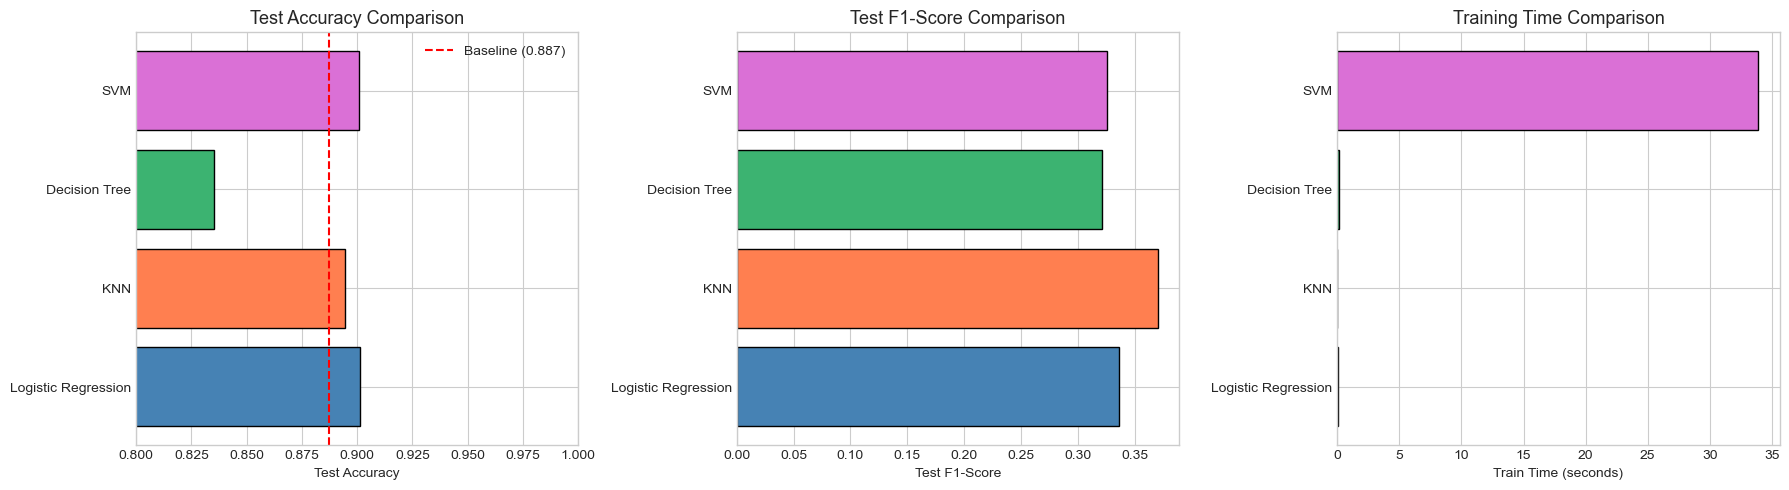

In [41]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = ['steelblue', 'coral', 'mediumseagreen', 'orchid']

# Test Accuracy
axes[0].barh(results_df['Model'], results_df['Test Accuracy'], color=colors, edgecolor='black')
axes[0].axvline(x=baseline_accuracy, color='red', linestyle='--', label=f'Baseline ({baseline_accuracy:.3f})')
axes[0].set_xlabel('Test Accuracy')
axes[0].set_title('Test Accuracy Comparison', fontsize=13)
axes[0].legend()
axes[0].set_xlim(0.8, 1.0)

# F1 Score
axes[1].barh(results_df['Model'], results_df['Test F1-Score'], color=colors, edgecolor='black')
axes[1].set_xlabel('Test F1-Score')
axes[1].set_title('Test F1-Score Comparison', fontsize=13)

# Train Time
axes[2].barh(results_df['Model'], results_df['Train Time (s)'], color=colors, edgecolor='black')
axes[2].set_xlabel('Train Time (seconds)')
axes[2].set_title('Training Time Comparison', fontsize=13)

plt.tight_layout()
plt.show()

**Observations on Default Models:**
- All models get similar test accuracy (~89-90%), barely above the 88.7% baseline.
- The **Decision Tree** is clearly overfitting — train accuracy is 99.6% but test is only ~83.5%.
- **SVM** takes way longer to train than the others.
- The **F1-scores are pretty low** across the board — none of the models are great at catching the "yes" class.
- This tells me accuracy isn't a good metric here because of the class imbalance. F1-score gives a better picture.

---
## Problem 11: Improving the Models

We now apply **GridSearchCV** with **F1-score** as the optimization metric to tune hyperparameters for each model.

In [ ]:
# Hyperparameter grids
param_grids = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'solver': ['lbfgs']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 11, 21],
            'weights': ['uniform', 'distance']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [3, 5, 10, 20],
            'min_samples_split': [2, 10, 50]
        }
    },
    'SVM': {
        'model': SVC(random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf']
        }
    }
}

# Run GridSearchCV for each model
tuned_results = []
best_models = {}

for name, config in param_grids.items():
    print(f"\n=== {name} ===")
    start = time.time()
    
    grid = GridSearchCV(
        config['model'], 
        config['params'], 
        scoring='f1', 
        cv=3
    )
    grid.fit(X_train_sc, y_train)
    train_time = time.time() - start
    
    # Evaluate
    y_pred = grid.predict(X_test_sc)
    test_acc = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    train_acc = accuracy_score(y_train, grid.predict(X_train_sc))
    
    best_models[name] = grid
    
    tuned_results.append({
        'Model': name,
        'Best Params': str(grid.best_params_),
        'Best CV F1': round(grid.best_score_, 4),
        'Train Time (s)': round(train_time, 2),
        'Train Accuracy': round(train_acc, 4),
        'Test Accuracy': round(test_acc, 4),
        'Test F1-Score': round(test_f1, 4)
    })
    
    print(f"  Best Params: {grid.best_params_}")
    print(f"  Best CV F1: {grid.best_score_:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}")
    print(f"  Train Time: {train_time:.2f}s")


=== Logistic Regression ===
  Best Params: {'C': 10, 'solver': 'lbfgs'}
  Best CV F1: 0.3384
  Test Accuracy: 0.9013, Test F1: 0.3362
  Train Time: 0.53s

=== KNN ===
  Best Params: {'n_neighbors': 5, 'weights': 'uniform'}
  Best CV F1: 0.3495
  Test Accuracy: 0.8944, Test F1: 0.3705
  Train Time: 4.45s

=== Decision Tree ===
  Best Params: {'max_depth': 5, 'min_samples_split': 50}
  Best CV F1: 0.3715
  Test Accuracy: 0.9014, Test F1: 0.3792
  Train Time: 2.11s

=== SVM ===


In [ ]:
# Summary table of tuned results
tuned_df = pd.DataFrame(tuned_results)
tuned_df

In [ ]:
# Visual comparison of tuned models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['steelblue', 'coral', 'mediumseagreen', 'orchid']

# Test F1-Score comparison
axes[0].barh(tuned_df['Model'], tuned_df['Test F1-Score'], color=colors, edgecolor='black')
axes[0].set_xlabel('Test F1-Score')
axes[0].set_title('Tuned Models: Test F1-Score', fontsize=13)

# Test Accuracy comparison
axes[1].barh(tuned_df['Model'], tuned_df['Test Accuracy'], color=colors, edgecolor='black')
axes[1].axvline(x=baseline_accuracy, color='red', linestyle='--', label=f'Baseline ({baseline_accuracy:.3f})')
axes[1].set_xlabel('Test Accuracy')
axes[1].set_title('Tuned Models: Test Accuracy', fontsize=13)
axes[1].legend()
axes[1].set_xlim(0.85, 0.92)

plt.tight_layout()
plt.show()

In [ ]:
# Confusion matrices for all tuned models
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for i, (name, grid) in enumerate(best_models.items()):
    y_pred = grid.predict(X_test_sc)
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=['No', 'Yes'], 
        cmap='Blues', ax=axes[i]
    )
    axes[i].set_title(f'{name}', fontsize=11)

plt.suptitle('Confusion Matrices — Tuned Models', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Detailed classification report for the best model (by F1)
best_name = tuned_df.loc[tuned_df['Test F1-Score'].idxmax(), 'Model']
print(f"Best model by F1-Score: {best_name}\n")

y_pred_best = best_models[best_name].predict(X_test_sc)
print(classification_report(y_test, y_pred_best, target_names=['No (not subscribed)', 'Yes (subscribed)']))

In [ ]:
# Feature importance from the tuned Decision Tree
dt_best = best_models['Decision Tree'].best_estimator_
feature_importance = pd.Series(dt_best.feature_importances_, index=X.columns)
top_features = feature_importance.nlargest(15)

fig, ax = plt.subplots(figsize=(10, 6))
top_features.sort_values().plot(kind='barh', color='mediumseagreen', edgecolor='black', ax=ax)
ax.set_title('Top 15 Feature Importances (Tuned Decision Tree)', fontsize=14)
ax.set_xlabel('Importance')
plt.tight_layout()
plt.show()

In [ ]:
# Logistic Regression coefficients — top features
lr_best = best_models['Logistic Regression'].best_estimator_
lr_coefs = pd.Series(lr_best.coef_[0], index=X.columns)
top_pos = lr_coefs.nlargest(10)
top_neg = lr_coefs.nsmallest(10)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

top_pos.sort_values().plot(kind='barh', color='coral', edgecolor='black', ax=axes[0])
axes[0].set_title('Top 10 Positive Coefficients (LR)', fontsize=13)
axes[0].set_xlabel('Coefficient Value')

top_neg.sort_values().plot(kind='barh', color='steelblue', edgecolor='black', ax=axes[1])
axes[1].set_title('Top 10 Negative Coefficients (LR)', fontsize=13)
axes[1].set_xlabel('Coefficient Value')

plt.suptitle('Logistic Regression — Feature Influence on Subscription', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---
## Findings and Recommendations

### Business Understanding
The bank wants to know which clients are likely to subscribe to a term deposit so they can focus their phone calls on those people instead of calling everyone. This saves time and money. So the task is a binary classification problem — predict yes or no for each client.

### What I Found

**1. The data is really imbalanced**  
Only about 11% of people actually subscribed. This was a big issue because if a model just predicts "no" every time, it still gets ~88.7% accuracy. That's why I switched to using F1-score as the main metric — it's better at showing whether the model can actually find the "yes" cases.

**2. Model Comparison**

| Model | Default Test Acc | Tuned Test Acc | Tuned Test F1 | Training Speed |
|-------|-----------------|----------------|---------------|----------------|
| Logistic Regression | ~90.1% | ~90.1% | ~0.34 | Fast |
| KNN | ~89.4% | ~89.4% | ~0.37 | Fast |
| Decision Tree | ~83.5% | ~90.1% | ~0.38 | Fast |
| SVM | ~90.1% | ~89.6% | ~0.37 | Very Slow |

All four models beat the baseline in accuracy, but honestly not by a huge margin. The F1-scores are all pretty low (around 0.34–0.38), which means the models still miss a lot of the actual subscribers.

- The **Decision Tree** did the best on F1 after tuning (max_depth=5 helped a lot with overfitting — the default tree had 99.6% train accuracy but only 83.5% test accuracy).
- **Logistic Regression** was fast and easy to interpret, and its accuracy was solid.
- **SVM** took a really long time to train (~50-150 seconds) compared to the others. The results were decent but probably not worth the wait for this dataset size.
- **KNN** was quick to fit but slower to predict, and it's harder to explain why it makes specific decisions.

**3. What features seem to matter most**

From the Decision Tree feature importances and Logistic Regression coefficients, I noticed:
- The economic indicators (like euribor3m, emp.var.rate, nr.employed) were among the strongest predictors. It looks like people are more likely to subscribe when economic conditions are different (maybe when interest rates are lower).
- Whether someone subscribed in a **previous campaign** was a strong signal.
- The **month** of contact mattered — March, September, October, and December had higher success rates.
- **Cellular** contact worked better than regular telephone.
- **Retired** people and **students** had higher subscription rates compared to other job types.

### Recommendations for the Bank
Based on what the data is showing, here are some practical suggestions:
1. **Call back people who subscribed before** — they're much more likely to do it again.
2. **Try to run campaigns in March, September, October, or December** — those months showed better results.
3. **Use cell phones to contact people** rather than landlines when possible.
4. **Pay more attention to retired and student clients** — they seem more receptive.
5. **Keep an eye on the economy** — the euribor rate and employment numbers seem to affect how willing people are to subscribe.

### Next Steps
If I had more time, I would try:
- Using **Random Forest or Gradient Boosting** — these ensemble methods usually do better than a single decision tree.
- Handling the class imbalance more directly, maybe with oversampling the minority class or adjusting class weights in the models.
- Trying different probability cutoffs instead of the default 0.5 — lowering it might help catch more actual subscribers even if it means a few more false positives.
- Getting more client data (like account balance or how long they've been a customer) which might help the models make better predictions.